# YAW pipeline testing 
To run this in production mode use `measure_yaw-w-random.py`.

In [1]:
# measure n(z)
import yaw
import os
import shutil
# check
import numpy as np
from astropy.io import fits
import pylab as pl

import healpy as hp

from yaw.correlation import autocorrelate_scalar, crosscorrelate_scalar
from yaw import autocorrelate
from yaw.utils import parallel
from yaw import crosscorrelate

import pandas as pd

from yaw.correlation.corrfunc import ScalarCorrFunc

In [2]:
def delete_and_recreate_cache_directory(cache_dir):
    if parallel.on_root():  # if running with MPI, this is only executed on rank 0
        if os.path.exists(cache_dir):
            shutil.rmtree(cache_dir)
        os.mkdir(cache_dir)

In [3]:
njn=64
# here can test a range of scales
theta_min=[5,10,15]
theta_max=[15,30,50]
theta_scaled=None
resolution=None
unit='arcmin'

sim_mode_tag = "raw"
type_tag = "unknown"

ref_name = 'DELTA_F'
ref_weight_name = 'NPIX'

Delta F from raw catalog

In [20]:
sim_num = 0
unk_zcut = [1.8,3.0]

outroot = "/pscratch/sd/q/qhang/desi-lya/results/"

saveroot = outroot + f"run-{sim_num}/"
path_unknown = saveroot + f"catalogue/{type_tag}-zmin-{unk_zcut[0]}-zmax-{unk_zcut[1]}.fits"
path_reference = saveroot + f"catalogue/delta-{sim_mode_tag}.fits"
path_unk_rand = "/pscratch/sd/q/qhang/desi-lya/random-catalogue-overlap-w-z.fits"

In [5]:
# here use 40 bins, but we can test 20 bin case later:
edges = np.linspace(2,3,21)
zsamp = (edges[1:] + edges[:-1])/2.

In [6]:
# turn on logging to terminal (can change level to "info" or remove this line entirely)
#get_logger(level="info", pretty=True, capture_warnings=True)
PROGRESS = True  # if you want to see a progress bar

# CONFIGURATION
patch_num = njn # code will generate this number of patch centers from the reference randoms
config = yaw.Configuration.create(
    rmin=theta_min,  # scalar or list of lower scale cuts
    rmax=theta_max,
    unit=unit,
    rweight=theta_scaled,
    resolution=resolution,
    edges=edges,
)

In [8]:
# LOADING CATALOGS
CACHE_DIR = saveroot + f"yaw-20bin/cache_{sim_mode_tag}"
#delete_and_recreate_cache_directory(CACHE_DIR)

In [9]:
# set up the catalogues:
cat_unknown = yaw.Catalog.from_file(
    cache_directory=os.path.join(CACHE_DIR, "unknown"),
    path=path_unknown,
    ra_name="RA",
    dec_name="DEC",
    redshift_name="Z",
    #weight_name="weight_column",  # optional
    patch_num=patch_num,
    progress=PROGRESS,
    degrees=True,
)
patch_centers = cat_unknown.get_centers()

Process Process-66:t=0m00.00s
Traceback (most recent call last):
  File "/global/homes/q/qhang/.conda/envs/yaw_env/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/global/homes/q/qhang/.conda/envs/yaw_env/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/catalog/catalog.py", line 812, in task
    with CatalogWriter(
         ^^^^^^^^^^^^^^
  File "/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/catalog/catalog.py", line 453, in __init__
    raise FileExistsError(f"cache directory exists: {cache_directory}")
FileExistsError: cache directory exists: /pscratch/sd/q/qhang/desi-lya/results/run-0/yaw-20bin/cache_raw/unknown
processed 7/7 (100%) t=0m08.53s
processed 64/64 (100%) t=0m01.30s


In [10]:
cat_reference = yaw.Catalog.from_file(
    cache_directory=os.path.join(CACHE_DIR, "reference"),
    path=path_reference,
    ra_name="RA",
    dec_name="DEC",
    redshift_name="Z",
    weight_name=ref_weight_name,
    kappa_name=ref_name,
    patch_centers=patch_centers,
    progress=PROGRESS,
    degrees=True,
)

Process Process-196:=0m00.00s
Traceback (most recent call last):
  File "/global/homes/q/qhang/.conda/envs/yaw_env/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/global/homes/q/qhang/.conda/envs/yaw_env/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/catalog/catalog.py", line 812, in task
    with CatalogWriter(
         ^^^^^^^^^^^^^^
  File "/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/catalog/catalog.py", line 453, in __init__
    raise FileExistsError(f"cache directory exists: {cache_directory}")
FileExistsError: cache directory exists: /pscratch/sd/q/qhang/desi-lya/results/run-0/yaw-20bin/cache_raw/reference
processed 1/1 (100%) t=0m01.19s
processed 64/64 (100%) t=0m01.31s


In [31]:
cat_reference = yaw.Catalog(cache_directory=os.path.join(CACHE_DIR, "reference"))

In [11]:
cat_ref_rand = None

In [21]:
cat_unk_rand = yaw.Catalog.from_file(
    cache_directory=os.path.join(CACHE_DIR, "unk_rand"),
    path=path_unk_rand,
    ra_name="RA",
    dec_name="DEC",
    redshift_name="Z",
    patch_centers=patch_centers,
    progress=PROGRESS,
    degrees=True,
)

Process Process-582:t=0m00.00s
Traceback (most recent call last):
  File "/global/homes/q/qhang/.conda/envs/yaw_env/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/global/homes/q/qhang/.conda/envs/yaw_env/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/catalog/catalog.py", line 812, in task
    with CatalogWriter(
         ^^^^^^^^^^^^^^
  File "/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/catalog/catalog.py", line 453, in __init__
    raise FileExistsError(f"cache directory exists: {cache_directory}")
FileExistsError: cache directory exists: /pscratch/sd/q/qhang/desi-lya/results/run-0/yaw-20bin/cache_raw/unk_rand
processed 11/11 (100%) t=0m18.37s
processed 64/64 (100%) t=0m01.53s


In [14]:
# measurements:
w_ss= autocorrelate_scalar(
    config,
    cat_reference,
    progress=PROGRESS
) # returns a list, one for each scale, just pick the first here
#   w_ss.to_file("...") -> store correlation pair counts as HDF5 file

processed 64/64 (100%) t=0m01.51s
processed 203/203 (100%) t=0m02.14s
processed 203/203 (100%) t=0m02.36s


/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:703: RuntimeWarning: invalid value encountered in divide
  data = kk_counts.data / nn_counts.data
/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:704: RuntimeWarning: invalid value encountered in divide
  samples = kk_counts.samples / nn_counts.samples


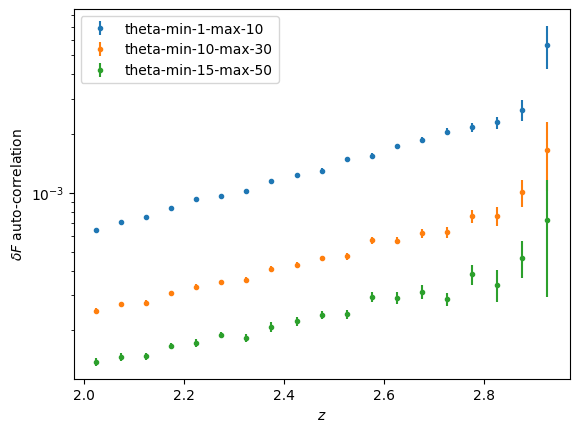

In [16]:
for ii in range(len(theta_min)):
    cts_ss = w_ss[ii]
    cts_ss.to_file(saveroot + f"yaw-20bin/w_ss-{sim_mode_tag}-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
    cts_ss.sample().plot(label=f"theta-min-{theta_min[ii]}-max-{theta_max[ii]}")
    pl.xlabel("$z$")
    pl.ylabel("$\\delta F$ auto-correlation")
    pl.yscale('log')
    pl.legend()

In [22]:
w_sp = crosscorrelate_scalar(
    config,
    cat_reference,
    cat_unknown,
    unk_rand=cat_unk_rand,
    progress=True,  # shows a progress bar, default: False
)

processed 64/64 (100%) t=0m01.10s
processed 64/64 (100%) t=0m01.23s
processed 64/64 (100%) t=0m01.20s
processed 346/346 (100%) t=1m09.92s
processed 346/346 (100%) t=1m10.66s
processed 346/346 (100%) t=2m01.72s
processed 346/346 (100%) t=2m03.44s


/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:703: RuntimeWarning: invalid value encountered in divide
  data = kk_counts.data / nn_counts.data
/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:704: RuntimeWarning: invalid value encountered in divide
  samples = kk_counts.samples / nn_counts.samples


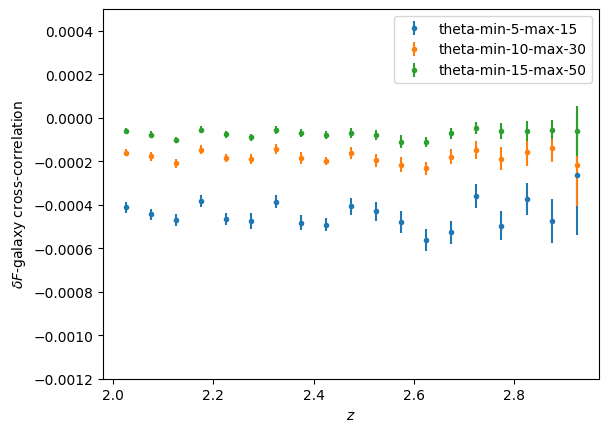

In [23]:
for ii in range(len(theta_min)):
    cts_sp = w_sp[ii]
    cts_sp.to_file(saveroot + f"yaw-20bin/w_sp-{sim_mode_tag}-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
    cts_sp.sample().plot(label=f"theta-min-{theta_min[ii]}-max-{theta_max[ii]}")
    pl.xlabel("$z$")
    pl.ylabel("$\\delta F$-galaxy cross-correlation")
    #pl.yscale('log')
    pl.legend()
    pl.ylim([-0.0012,0.0005])

In [20]:
wppfname = saveroot + f"yaw-20bin/w_pp-theta-min-{theta_min[0]}-max-{theta_max[0]}.hdf5"
if os.path.isfile(wppfname)!=True:
    # also run unknown case:
    w_pp = autocorrelate(
        config,
        cat_unknown,
        random=cat_unk_rand,
        progress=PROGRESS
    )
    for ii in range(len(theta_min)):
        cts_pp = w_pp[ii]
        cts_pp.to_file(saveroot + f"yaw-20bin/w_pp-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")

processed 64/64 (100%) t=0m04.13s
processed 64/64 (100%) t=0m06.04s
processed 205/205 (100%) t=1m06.42s
processed 346/346 (100%) t=1m30.09s
processed 205/205 (100%) t=2m11.89s


Text(0, 0.5, 'galaxy auto-correlation')

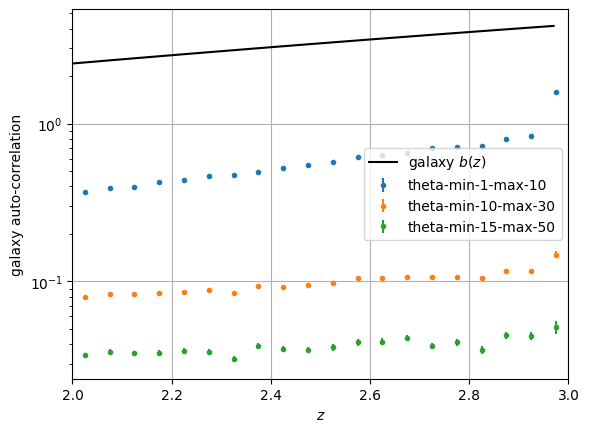

In [21]:
for ii in range(len(theta_min)):
    cts_pp = w_pp[ii]
    cts_pp.sample().plot(label=f"theta-min-{theta_min[ii]}-max-{theta_max[ii]}")

pl.yscale('log')
pl.grid()

# load and plot bias evolution curve:
bz = np.loadtxt("../bias_dc2.txt")
pl.plot(bz[:,0],bz[:,1],label="galaxy $b(z)$",color='k')
pl.xlim([2,3])

pl.legend()

pl.xlabel("$z$")
pl.ylabel("galaxy auto-correlation")

In [22]:
# load back the correlations:
w_ss=[]
w_sp=[]
w_pp=[]
for ii in range(len(theta_min)):
    fname = saveroot + f"yaw-20bin/w_ss-{sim_mode_tag}-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5"
    w_ss.append(ScalarCorrFunc.from_file(fname))

    fname = saveroot + f"yaw-20bin/w_sp-{sim_mode_tag}-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5"
    w_sp.append(ScalarCorrFunc.from_file(fname))

    fname = saveroot + f"yaw-20bin/w_pp-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5"
    w_pp.append(yaw.CorrFunc.from_file(fname))

In [23]:
nz_true = np.loadtxt("/pscratch/sd/q/qhang/desi-lya/nz-gal-z1.8-3.0-box-0-interp-for-rand.txt")
ind=(nz_true[:,1]>0)
nz_dz = nz_true[1,0] - nz_true[0,0]
nz_norm = (nz_true[:,1]/np.sum(nz_true[:,1])/nz_dz)[ind]
nz_zsamp = nz_true[ind,0]

Text(0.5, 1.0, '$n(z) = w_{\\rm ru}/\\sqrt{w_{\\rm rr} w_{\\rm uu}}\\Delta z$')

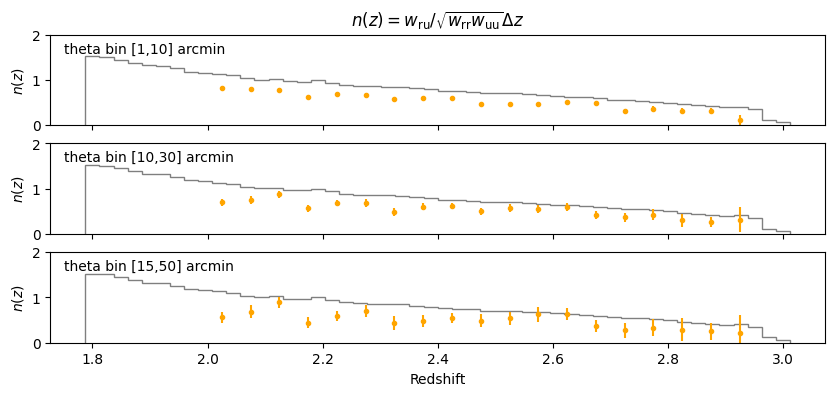

In [43]:
fig,axarr=pl.subplots(3,figsize=[10,4],sharex=True)

for ii in range(len(theta_min)):
    pl.sca(axarr[ii])
    
    cts_sp = w_sp[ii]
    cts_ss = w_ss[ii]
    cts_pp = w_pp[ii]
    
    zz = cts_sp.binning.mids
    sp = cts_sp.sample().data
    ss = cts_ss.sample().data
    pp = cts_pp.sample().data

    # get errorbar:
    samps = cts_sp.sample().samples/np.sqrt((cts_ss.sample().samples)*(cts_pp.sample().samples))
    std = np.std(samps,axis=0)*np.sqrt(64)
    
    deltaz = zz[1]-zz[0]
    pl.errorbar(zz, -sp/np.sqrt(ss*pp)/deltaz,yerr=std/deltaz,fmt='.',color='orange')
    
    # get true redshift distribution from sim:
    nz_edges = np.append(nz_zsamp-nz_dz/2., nz_zsamp[-1]+nz_dz/2.)
    pl.stairs(nz_norm,nz_edges, color='k', alpha=0.5)
    
    pl.ylabel("$n(z)$")
    pl.ylim([0,2])

    pl.text(1.75,1.6,f"theta bin [{theta_min[ii]},{theta_max[ii]}] arcmin")
pl.xlabel("Redshift")
pl.sca(axarr[0])
pl.title("$n(z) = w_{\\rm ru}/\\sqrt{w_{\\rm rr} w_{\\rm uu}}\\Delta z$")

Text(0.5, 1.0, '$n(z) \\propto w_{\\rm ru}/\\sqrt{w_{\\rm rr}}\\Delta z$')

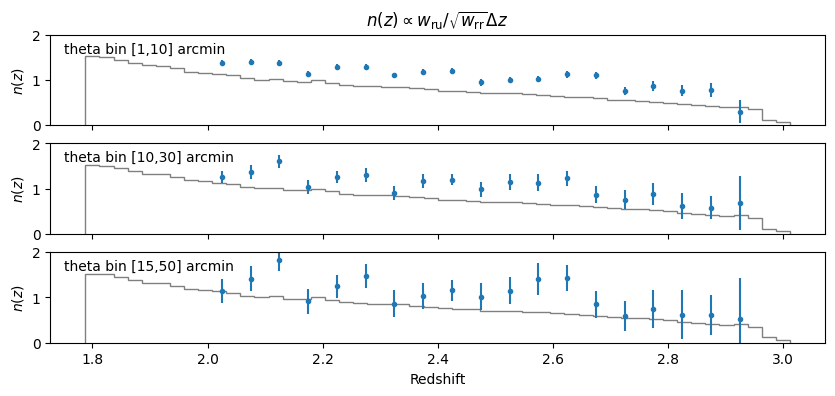

In [59]:
fig,axarr=pl.subplots(3,figsize=[10,4],sharex=True)

# here using yaw without the w_pp information:
for ii in range(len(theta_min)):
    pl.sca(axarr[ii])
    
    cts_sp = w_sp[ii]
    cts_ss = w_ss[ii]
    #cts_pp = w_pp[ii]
    ncc = yaw.RedshiftData.from_corrfuncs(
        cross_corr=cts_sp,
        ref_corr=cts_ss,
        unk_corr=None,
    )
    
    # or even with estimated normalisation
    ncc.normalised().plot()
    
    pl.ylabel("$n(z)$")
    pl.ylim([0,2])
    pl.text(1.75,1.6,f"theta bin [{theta_min[ii]},{theta_max[ii]}] arcmin")
    
    # get true redshift distribution from sim:
    nz_edges = np.append(nz_zsamp-nz_dz/2., nz_zsamp[-1]+nz_dz/2.)
    pl.stairs(nz_norm,nz_edges, color='k', alpha=0.5)
    #pl.stairs(cc[0]/sum(cc[0])/0.05, cc[1], color='k', alpha=0.5)
pl.xlabel("Redshift")
pl.sca(axarr[0])
pl.title("$n(z) \\propto w_{\\rm ru}/\\sqrt{w_{\\rm rr}}\\Delta z$")

## Without random

In [12]:
cat_unk_rand = None 

In [13]:
w_sp = crosscorrelate_scalar(
    config,
    cat_reference,
    cat_unknown,
    unk_rand=cat_unk_rand,
    progress=True,  # shows a progress bar, default: False
)

processed 64/64 (100%) t=0m01.23s
processed 64/64 (100%) t=0m01.15s
processed 346/346 (100%) t=1m10.55s
processed 346/346 (100%) t=1m09.70s


In [ ]:
for ii in range(len(theta_min)):
    cts_sp = w_sp[ii]
    cts_sp.to_file(saveroot + f"yaw-20bin/w_sp-{sim_mode_tag}-norand-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
    cts_sp.sample().plot(label=f"theta-min-{theta_min[ii]}-max-{theta_max[ii]}")

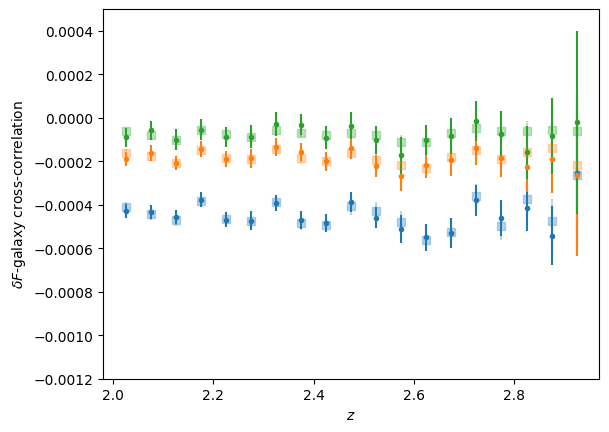

In [30]:
for ii in range(len(theta_min)):
    cts_sp = ScalarCorrFunc.from_file(saveroot + f"yaw-20bin/w_sp-{sim_mode_tag}-norand-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
    pl.errorbar(cts_sp.binning.mids, cts_sp.sample().data, yerr=cts_sp.sample().error, fmt='.')

    cts_sp = ScalarCorrFunc.from_file(saveroot + f"yaw-20bin/w_sp-{sim_mode_tag}-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
    pl.errorbar(cts_sp.binning.mids, cts_sp.sample().data, yerr=cts_sp.sample().error, fmt='s',color=f'C{ii}',alpha=0.3)
    
    pl.xlabel("$z$")
    pl.ylabel("$\\delta F$-galaxy cross-correlation")
    #pl.yscale('log')
    #pl.legend()
    pl.ylim([-0.0012,0.0005])

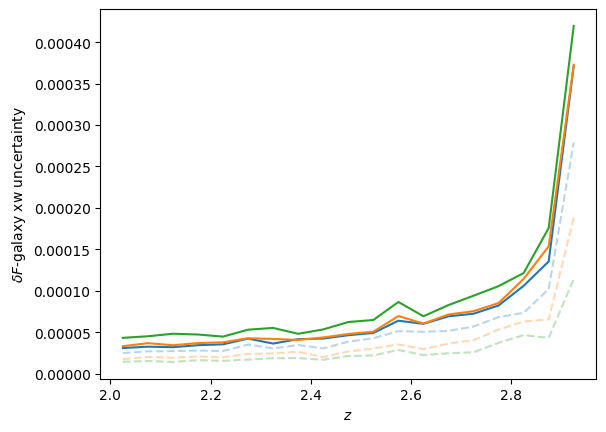

In [29]:
# let's compare their error bars here:
for ii in range(len(theta_min)):
    cts_sp = ScalarCorrFunc.from_file(saveroot + f"yaw-20bin/w_sp-{sim_mode_tag}-norand-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
    pl.plot(cts_sp.binning.mids, cts_sp.sample().error, '-')

    cts_sp = ScalarCorrFunc.from_file(saveroot + f"yaw-20bin/w_sp-{sim_mode_tag}-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
    pl.plot(cts_sp.binning.mids, cts_sp.sample().error, '--', color=f'C{ii}',alpha=0.3)
    pl.xlabel("$z$")
    pl.ylabel("$\\delta F$-galaxy xw uncertainty")
    #pl.yscale('log')
    #pl.ylim([-0.0012,0.0005])

# Measure the QSO-galaxy correlation

In [4]:
outroot = "/pscratch/sd/q/qhang/desi-lya/results/"
sim_num = 0
type_tag = "unknown"
unk_tag = ""
unk_zcut=[1.8,3.0]
ref_tag = "-20bin"
sim_mode_tag = "raw"
yaw_tag = "-20bin"
rand_z_name = "Z"

In [5]:
saveroot = outroot + f"run-{sim_num}/"
path_unknown = saveroot + f"catalogue/{type_tag}{unk_tag}-zmin-{unk_zcut[0]}-zmax-{unk_zcut[1]}.fits"
path_reference = saveroot + f"catalogue{ref_tag}/delta-{sim_mode_tag}.fits"
path_unk_rand = "/pscratch/sd/q/qhang/desi-lya/random-catalogue-overlap-w-z.fits"

In [20]:
zbins = [2,3,20]
edges = np.linspace(float(zbins[0]), float(zbins[1]), int(zbins[2])+1)
zsamp = (edges[1:] + edges[:-1])/2.

In [21]:
# turn on logging to terminal (can change level to "info" or remove this line entirely)
#get_logger(level="info", pretty=True, capture_warnings=True)
PROGRESS = True  # if you want to see a progress bar

# CONFIGURATION
patch_num = njn # code will generate this number of patch centers from the reference randoms
config = yaw.Configuration.create(
    rmin=theta_min,  # scalar or list of lower scale cuts
    rmax=theta_max,
    unit=unit,
    rweight=theta_scaled,
    resolution=resolution,
    edges=edges,
)

# LOADING CATALOGS
CACHE_DIR = saveroot + f"yaw{yaw_tag}/cache_{sim_mode_tag}-QSO/"
print("cache: ", CACHE_DIR)

delete_and_recreate_cache_directory(CACHE_DIR)

# set up the catalogues:
cat_unknown = yaw.Catalog.from_file(
    cache_directory=os.path.join(CACHE_DIR, "unknown"),
    path=path_unknown,
    ra_name="RA",
    dec_name="DEC",
    redshift_name="Z",
    #weight_name="weight_column",  # optional
    patch_num=patch_num,
    progress=PROGRESS,
    degrees=True,
)
patch_centers = cat_unknown.get_centers()


cat_reference = yaw.Catalog.from_file(
    cache_directory=os.path.join(CACHE_DIR, "reference"),
    path=path_reference,
    ra_name="RA",
    dec_name="DEC",
    redshift_name="Z",
    #weight_name=ref_weight_name,
    #kappa_name=ref_name,
    patch_centers=patch_centers,
    progress=PROGRESS,
    degrees=True,
)

cat_ref_rand = None 
cat_unk_rand = yaw.Catalog.from_file(
    cache_directory=os.path.join(CACHE_DIR, "unk_rand"),
    path=path_unk_rand,
    ra_name="RA",
    dec_name="DEC",
    redshift_name=rand_z_name,
    patch_centers=patch_centers,
    progress=PROGRESS,
    degrees=True,
)

print("Done loading catalogues")

cache:  /pscratch/sd/q/qhang/desi-lya/results/run-0/yaw-20bin/cache_raw-QSO/


processed 7/7 (100%) t=0m10.24s
processed 64/64 (100%) t=0m02.28s
processed 1/1 (100%) t=0m00.59s
processed 64/64 (100%) t=0m01.47s
processed 11/11 (100%) t=0m20.82s
processed 64/64 (100%) t=0m02.77s


Done loading catalogues


In [22]:
print("Computing w_sp")
w_sp = crosscorrelate(
    config,
    cat_reference,
    cat_unknown,
    ref_rand=cat_unk_rand,
    progress=PROGRESS
)

processed 0/64 (0%) t=0m00.00s

Computing w_sp


processed 64/64 (100%) t=0m01.41s
processed 64/64 (100%) t=0m06.48s
processed 64/64 (100%) t=0m04.10s
processed 346/346 (100%) t=1m15.99s
processed 346/346 (100%) t=39m54.99s


In [33]:
# load results:
w_sp= []
for ii in range(len(theta_min)):
    cts_pp = yaw.CorrFunc.from_file(saveroot + f"yaw-20bin/w_sp-QSO-raw-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
    w_sp.append(cts_pp)

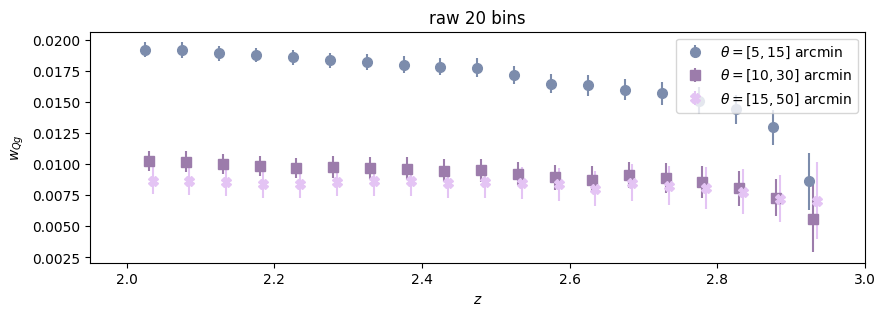

In [35]:
fig,axarr=pl.subplots(figsize=[10,3])
fmt=['o','s','X']
color=['#7c8cac','#9c7cab','#e4c4f4']
#label=["Picca", "LyCAN"]
Nbins=20

mode = "raw"
for jj in range(len(theta_min)):
    label = f"$\\theta = [{theta_min[jj]}, {theta_max[jj]}]$ arcmin"
    pl.errorbar(zsamp + jj*0.005, w_sp[jj].sample().data, 
               yerr = w_sp[jj].sample().error, fmt=fmt[jj], label=label,color=color[jj],markersize=7)
pl.title(mode + f" {Nbins} bins")


#pl.plot([1.8,3.0],[1,1],'k-')
#pl.stairs(nz_norm,nz_edges, color='k', label='truth')
pl.xlim([1.95,3.0])
#pl.ylim([0.6, 1.1])

pl.legend()
pl.xlabel("$z$")
pl.ylabel("$w_{Qg}$")
pl.savefig("../plots/w_Qg-scales-20bin-raw.pdf", bbox_inches="tight")

In [ ]:
# need to rerun above to save things

# Meausre corss-corrleation within a bin:

In [36]:
outroot = "/pscratch/sd/q/qhang/desi-lya/results/"
sim_num = 0
type_tag = "unknown"
unk_tag = ""
unk_zcut=[1.8,3.0]
ref_tag = "-20bin"
sim_mode_tag = "raw"
yaw_tag = "-20bin"
rand_z_name = "Z"

In [37]:
saveroot = outroot + f"run-{sim_num}/"
path_unknown = saveroot + f"catalogue/{type_tag}{unk_tag}-zmin-{unk_zcut[0]}-zmax-{unk_zcut[1]}.fits"
path_reference = saveroot + f"catalogue{ref_tag}/delta-{sim_mode_tag}.fits"
path_unk_rand = "/pscratch/sd/q/qhang/desi-lya/random-catalogue-overlap-w-z.fits"

In [38]:
zbins = [2,3,20]
edges = np.linspace(float(zbins[0]), float(zbins[1]), int(zbins[2])+1)
zsamp = (edges[1:] + edges[:-1])/2.

In [13]:
# turn on logging to terminal (can change level to "info" or remove this line entirely)
#get_logger(level="info", pretty=True, capture_warnings=True)
PROGRESS = True  # if you want to see a progress bar

# CONFIGURATION
patch_num = njn

# LOADING CATALOGS
CACHE_DIR = saveroot + f"yaw{yaw_tag}/cache_{sim_mode_tag}-zbins/"
print("cache: ", CACHE_DIR)

delete_and_recreate_cache_directory(CACHE_DIR)

# set up the catalogues:
cat_ref_rand = None 

cat_unk_rand = yaw.Catalog.from_file(
    cache_directory=os.path.join(CACHE_DIR, "unk_rand"),
    path=path_unk_rand,
    ra_name="RA",
    dec_name="DEC",
    redshift_name=rand_z_name,
    patch_num=patch_num,
    progress=PROGRESS,
    degrees=True,
)

patch_centers = cat_unk_rand.get_centers()

cat_reference = yaw.Catalog.from_file(
    cache_directory=os.path.join(CACHE_DIR, "reference"),
    path=path_reference,
    ra_name="RA",
    dec_name="DEC",
    redshift_name="Z",
    weight_name=ref_weight_name,
    kappa_name=ref_name,
    patch_centers=patch_centers,
    progress=PROGRESS,
    degrees=True,
)
print("Done loading catalogues")

cache:  /pscratch/sd/q/qhang/desi-lya/results/run-0/yaw-20bin/cache_raw-zbins/


processed 11/11 (100%) t=0m15.48s
processed 64/64 (100%) t=0m05.20s
processed 1/1 (100%) t=0m00.78s
processed 64/64 (100%) t=0m04.34s


Done loading catalogues


In [14]:
# load unknown data
fin = fits.open(path_unknown)
unknownz = fin[1].data['Z']
unknownz_bin = np.digitize(unknownz, edges)

In [20]:
# here define the unknown sample for each redshift slice: and measure the cross-correlation, save them:
W_SP = {}
for ii in range(len(edges)-1):
    print(f"Working on bin {ii}...")
    # here select the catalog:
    ind = unknownz_bin == ii + 1
    dataframe_unknown = {
        'RA': fin[1].data['RA'][ind],
        'DEC': fin[1].data['DEC'][ind],
        'Z': fin[1].data['Z'][ind],
    }
    # turn into pandas dataframe:
    dataframe_unknown = pd.DataFrame.from_dict(dataframe_unknown)
    
    cat_unknown = yaw.Catalog.from_dataframe(
        cache_directory=os.path.join(CACHE_DIR, f"unknown-bin{ii}"),
        dataframe=dataframe_unknown,
        ra_name="RA",
        dec_name="DEC",
        redshift_name="Z",
        #weight_name="weight_column",  # optional
        patch_centers=patch_centers,
        progress=PROGRESS,
        degrees=True,
    )

     # code will generate this number of patch centers from the reference randoms
    config = yaw.Configuration.create(
        rmin=theta_min,  # scalar or list of lower scale cuts
        rmax=theta_max,
        unit=unit,
        rweight=theta_scaled,
        resolution=resolution,
        edges=edges[ii:ii+2],
    )
    
    print("Computing w_sp")
    w_sp = crosscorrelate_scalar(
        config,
        cat_reference,
        cat_unknown,
        unk_rand=cat_unk_rand,
        progress=PROGRESS
    )

    W_SP[ii] = w_sp

Working on bin 0...


Process Process-1680:0m00.00s
Traceback (most recent call last):
  File "/global/homes/q/qhang/.conda/envs/yaw_env/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/global/homes/q/qhang/.conda/envs/yaw_env/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/catalog/catalog.py", line 812, in task
    with CatalogWriter(
         ^^^^^^^^^^^^^^
  File "/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/catalog/catalog.py", line 453, in __init__
    raise FileExistsError(f"cache directory exists: {cache_directory}")
FileExistsError: cache directory exists: /pscratch/sd/q/qhang/desi-lya/results/run-0/yaw-20bin/cache_raw-zbins/unknown-bin0
processed 1/1 (100%) t=0m00.57s
processed 64/64 (100%) t=0m04.78s
processed 0/64 (0%) t=0m00.00s

Computing w_sp


processed 64/64 (100%) t=0m04.09s
processed 64/64 (100%) t=0m05.12s
processed 64/64 (100%) t=0m05.26s
processed 346/346 (100%) t=0m05.71s
processed 346/346 (100%) t=0m04.76s
processed 346/346 (100%) t=0m17.63s
processed 346/346 (100%) t=0m16.87s


Working on bin 1...


processed 1/1 (100%) t=0m00.48s
processed 64/64 (100%) t=0m04.02s
processed 0/64 (0%) t=0m00.00s

Computing w_sp


processed 64/64 (100%) t=0m04.60s
processed 64/64 (100%) t=0m03.81s
processed 64/64 (100%) t=0m04.31s
processed 346/346 (100%) t=0m04.37s
processed 346/346 (100%) t=0m03.91s
processed 346/346 (100%) t=0m16.19s
processed 346/346 (100%) t=0m16.41s


Working on bin 2...


processed 1/1 (100%) t=0m00.52s
processed 64/64 (100%) t=0m04.02s
processed 0/64 (0%) t=0m00.00s

Computing w_sp


processed 64/64 (100%) t=0m04.38s
processed 64/64 (100%) t=0m03.81s
processed 64/64 (100%) t=0m04.41s
processed 346/346 (100%) t=0m03.83s
processed 346/346 (100%) t=0m04.83s
processed 346/346 (100%) t=0m15.74s
processed 346/346 (100%) t=0m16.19s


Working on bin 3...


processed 1/1 (100%) t=0m00.43s
processed 64/64 (100%) t=0m03.89s
processed 0/64 (0%) t=0m00.00s

Computing w_sp


processed 64/64 (100%) t=0m05.11s
processed 64/64 (100%) t=0m03.83s
processed 64/64 (100%) t=0m04.32s
processed 346/346 (100%) t=0m04.66s
processed 346/346 (100%) t=0m04.20s
processed 346/346 (100%) t=0m17.01s
processed 346/346 (100%) t=0m14.68s


Working on bin 4...


processed 1/1 (100%) t=0m00.43s
processed 64/64 (100%) t=0m03.28s
processed 0/64 (0%) t=0m00.00s

Computing w_sp


processed 64/64 (100%) t=0m04.25s
processed 64/64 (100%) t=0m04.16s
processed 64/64 (100%) t=0m04.04s
processed 346/346 (100%) t=0m03.85s
processed 346/346 (100%) t=0m04.50s
processed 346/346 (100%) t=0m13.62s
processed 346/346 (100%) t=0m14.53s


Working on bin 5...


processed 1/1 (100%) t=0m00.38s
processed 64/64 (100%) t=0m03.68s
processed 0/64 (0%) t=0m00.00s

Computing w_sp


processed 64/64 (100%) t=0m04.82s
processed 64/64 (100%) t=0m03.68s
processed 64/64 (100%) t=0m04.44s
processed 346/346 (100%) t=0m04.93s
processed 346/346 (100%) t=0m03.53s
processed 346/346 (100%) t=0m13.57s
processed 346/346 (100%) t=0m13.78s


Working on bin 6...


processed 1/1 (100%) t=0m00.46s
processed 64/64 (100%) t=0m03.89s
processed 0/64 (0%) t=0m00.00s

Computing w_sp


processed 64/64 (100%) t=0m05.00s
processed 64/64 (100%) t=0m04.11s
processed 64/64 (100%) t=0m04.07s
processed 346/346 (100%) t=0m04.44s
processed 346/346 (100%) t=0m03.82s
processed 346/346 (100%) t=0m13.94s
processed 346/346 (100%) t=0m13.35s


Working on bin 7...


processed 1/1 (100%) t=0m00.34s
processed 64/64 (100%) t=0m04.20s
processed 0/64 (0%) t=0m00.00s

Computing w_sp


processed 64/64 (100%) t=0m04.02s
processed 64/64 (100%) t=0m03.78s
processed 64/64 (100%) t=0m03.33s
processed 346/346 (100%) t=0m04.56s
processed 346/346 (100%) t=0m04.31s
processed 346/346 (100%) t=0m12.20s
processed 346/346 (100%) t=0m12.83s


Working on bin 8...


processed 1/1 (100%) t=0m00.39s
processed 64/64 (100%) t=0m03.40s
processed 0/64 (0%) t=0m00.00s

Computing w_sp


processed 64/64 (100%) t=0m04.21s
processed 64/64 (100%) t=0m03.58s
processed 64/64 (100%) t=0m04.75s
processed 346/346 (100%) t=0m04.14s
processed 346/346 (100%) t=0m04.41s
processed 346/346 (100%) t=0m12.34s
processed 346/346 (100%) t=0m12.27s


Working on bin 9...


processed 1/1 (100%) t=0m00.35s
processed 64/64 (100%) t=0m03.43s
processed 0/64 (0%) t=0m00.00s

Computing w_sp


processed 64/64 (100%) t=0m04.31s
processed 64/64 (100%) t=0m03.78s
processed 64/64 (100%) t=0m04.00s
processed 346/346 (100%) t=0m04.49s
processed 346/346 (100%) t=0m03.79s
processed 346/346 (100%) t=0m11.15s
processed 346/346 (100%) t=0m10.36s


Working on bin 10...


processed 1/1 (100%) t=0m00.36s
processed 64/64 (100%) t=0m03.73s
processed 0/64 (0%) t=0m00.00s

Computing w_sp


processed 64/64 (100%) t=0m04.75s
processed 64/64 (100%) t=0m03.59s
processed 64/64 (100%) t=0m04.50s
processed 346/346 (100%) t=0m04.30s
processed 346/346 (100%) t=0m03.70s
processed 346/346 (100%) t=0m11.16s
processed 346/346 (100%) t=0m10.17s


Working on bin 11...


processed 1/1 (100%) t=0m00.31s
processed 64/64 (100%) t=0m03.46s
processed 0/64 (0%) t=0m00.00s

Computing w_sp


processed 64/64 (100%) t=0m04.27s
processed 64/64 (100%) t=0m03.28s
processed 64/64 (100%) t=0m04.32s
processed 346/346 (100%) t=0m03.51s
processed 346/346 (100%) t=0m04.97s
processed 346/346 (100%) t=0m10.15s
processed 346/346 (100%) t=0m09.98s


Working on bin 12...


processed 1/1 (100%) t=0m00.31s
processed 64/64 (100%) t=0m03.60s
processed 0/64 (0%) t=0m00.00s

Computing w_sp


processed 64/64 (100%) t=0m04.22s
processed 64/64 (100%) t=0m03.35s
processed 64/64 (100%) t=0m04.62s
processed 346/346 (100%) t=0m03.54s
processed 346/346 (100%) t=0m04.52s
processed 346/346 (100%) t=0m09.06s
processed 346/346 (100%) t=0m09.04s


Working on bin 13...


processed 1/1 (100%) t=0m00.28s
processed 64/64 (100%) t=0m03.68s
processed 0/64 (0%) t=0m00.00s

Computing w_sp


processed 64/64 (100%) t=0m04.73s
processed 64/64 (100%) t=0m03.39s
processed 64/64 (100%) t=0m04.39s
processed 346/346 (100%) t=0m04.58s
processed 346/346 (100%) t=0m03.94s
processed 346/346 (100%) t=0m09.30s
processed 346/346 (100%) t=0m09.94s


Working on bin 14...


processed 1/1 (100%) t=0m00.28s
processed 64/64 (100%) t=0m03.70s
processed 0/64 (0%) t=0m00.00s

Computing w_sp


processed 64/64 (100%) t=0m04.61s
processed 64/64 (100%) t=0m03.37s
processed 64/64 (100%) t=0m04.36s
processed 346/346 (100%) t=0m04.54s
processed 346/346 (100%) t=0m03.85s
processed 346/346 (100%) t=0m09.60s
processed 346/346 (100%) t=0m08.48s


Working on bin 15...


processed 1/1 (100%) t=0m00.26s
processed 64/64 (100%) t=0m04.12s
processed 0/64 (0%) t=0m00.00s

Computing w_sp


processed 64/64 (100%) t=0m03.65s
processed 64/64 (100%) t=0m03.54s
processed 64/64 (100%) t=0m04.39s
processed 346/346 (100%) t=0m03.41s
processed 346/346 (100%) t=0m04.75s
processed 346/346 (100%) t=0m07.63s
processed 346/346 (100%) t=0m07.34s


Working on bin 16...


processed 1/1 (100%) t=0m00.27s
processed 64/64 (100%) t=0m04.58s
processed 0/64 (0%) t=0m00.00s

Computing w_sp


processed 64/64 (100%) t=0m04.35s
processed 64/64 (100%) t=0m03.57s
processed 64/64 (100%) t=0m04.38s
processed 346/346 (100%) t=0m03.70s
processed 346/346 (100%) t=0m04.80s
processed 346/346 (100%) t=0m06.65s
processed 346/346 (100%) t=0m07.24s


Working on bin 17...


processed 1/1 (100%) t=0m00.25s
processed 64/64 (100%) t=0m04.48s
processed 0/64 (0%) t=0m00.00s

Computing w_sp


processed 64/64 (100%) t=0m04.04s
processed 64/64 (100%) t=0m03.55s
processed 64/64 (100%) t=0m04.17s
processed 346/346 (100%) t=0m03.44s
processed 346/346 (100%) t=0m04.66s
processed 346/346 (100%) t=0m06.63s
processed 346/346 (100%) t=0m06.91s


Working on bin 18...


processed 1/1 (100%) t=0m00.26s
processed 64/64 (100%) t=0m04.57s
processed 0/64 (0%) t=0m00.00s

Computing w_sp


processed 64/64 (100%) t=0m03.45s
processed 64/64 (100%) t=0m03.41s
processed 64/64 (100%) t=0m03.82s
processed 346/346 (100%) t=0m03.49s
processed 346/346 (100%) t=0m04.35s
processed 346/346 (100%) t=0m05.49s
processed 346/346 (100%) t=0m05.72s


Working on bin 19...


processed 1/1 (100%) t=0m00.42s
processed 64/64 (100%) t=0m04.12s
processed 0/64 (0%) t=0m00.00s

Computing w_sp


UnboundLocalError: cannot access local variable 'weights' where it is not associated with a value

In [22]:
# plot below 
w_sp_theta = []
for ii in range(len(theta_min)):
    vec = np.zeros((len(edges)-1, 2))
    for jj in range(len(edges)-2):
        vec[jj,0] = W_SP[jj][ii].sample().data
        vec[jj,1] = W_SP[jj][ii].sample().error
    w_sp_theta.append(vec)

/tmp/ipykernel_1308862/881480504.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vec[jj,0] = W_SP[jj][ii].sample().data
/tmp/ipykernel_1308862/881480504.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vec[jj,1] = W_SP[jj][ii].sample().error


Text(0, 0.5, '$w_{sp}$ in zbins')

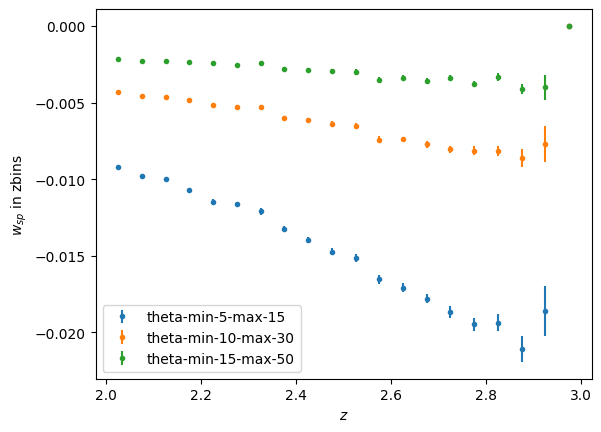

In [38]:
for ii in range(len(theta_min)):
    pl.errorbar(zsamp, w_sp_theta[ii][:,0], yerr=w_sp_theta[ii][:,1], fmt='.', 
                label=f"theta-min-{theta_min[ii]}-max-{theta_max[ii]}")
    if(0):
        # save the files:
        fname = saveroot + f"yaw-20bin/w_sp-zbins-{sim_mode_tag}-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.txt"
        np.savetxt(fname, np.c_[zsamp, w_sp_theta[ii]])
pl.legend()
pl.xlabel("$z$")
pl.ylabel("$w_{sp}$ in zbins")

In [39]:
def simple_corr_error_comb(w_sp, w_pp, w_ss):
    f1 = w_sp[:,1]/w_sp[:,0]
    f2 = w_ss[:,1]/w_ss[:,0]
    f3 = w_pp[:,1]/w_pp[:,0]
    f4 = np.sqrt(f1**2 + 0.5*(f2**2 + f3**2))
    r = w_sp[:,0]/np.sqrt(w_ss[:,0]*w_pp[:,0])
    return np.c_[r, r*f4]

In [40]:
# let's load the auto-correlations:
w_ss_theta = []
w_pp_theta = []
w_sp_theta = []
for ii in range(len(theta_min)):
    cts_ss = ScalarCorrFunc.from_file(saveroot + f"yaw-20bin/w_ss-{sim_mode_tag}-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
    cts_pp = yaw.CorrFunc.from_file(saveroot + f"yaw-20bin/w_pp-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.hdf5")
    fin = np.loadtxt(saveroot + f"yaw-20bin/w_sp-zbins-{sim_mode_tag}-theta-min-{theta_min[ii]}-max-{theta_max[ii]}.txt")
    
    w_ss_theta.append(cts_ss)
    w_pp_theta.append(cts_pp)
    w_sp_theta.append(fin[:,1:])

In [41]:
error_r = []
for ii in range(len(theta_min)):
    a = np.c_[w_ss_theta[ii].sample().data, w_ss_theta[ii].sample().error]
    b = np.c_[w_pp_theta[ii].sample().data, w_pp_theta[ii].sample().error]
    c = w_sp_theta[ii]
    error_r.append(simple_corr_error_comb(c, a, b))

/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:703: RuntimeWarning: invalid value encountered in divide
  data = kk_counts.data / nn_counts.data
/global/u2/q/qhang/desc/yet_another_wizz/src/yaw/correlation/paircounts.py:704: RuntimeWarning: invalid value encountered in divide
  samples = kk_counts.samples / nn_counts.samples
/tmp/ipykernel_1751788/3713362444.py:2: RuntimeWarning: invalid value encountered in divide
  f1 = w_sp[:,1]/w_sp[:,0]


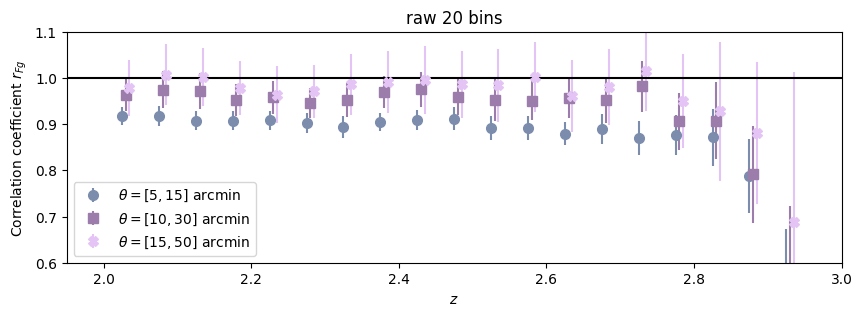

In [43]:
fig,axarr=pl.subplots(figsize=[10,3])
fmt=['o','s','X']
color=['#7c8cac','#9c7cab','#e4c4f4']
#label=["Picca", "LyCAN"]
Nbins=20

mode = "raw"
for jj in range(len(theta_min)):
    label = f"$\\theta = [{theta_min[jj]}, {theta_max[jj]}]$ arcmin"
    pl.errorbar(zsamp + jj*0.005, abs(error_r[jj][:,0]), yerr=abs(error_r[jj][:,1]),
                        fmt=fmt[jj], label=label,color=color[jj],markersize=7)
pl.title(mode + f" {Nbins} bins")


pl.plot([1.8,3.0],[1,1],'k-')
#pl.stairs(nz_norm,nz_edges, color='k', label='truth')
pl.xlim([1.95,3.0])
pl.ylim([0.6, 1.1])

pl.legend()
pl.xlabel("$z$")
pl.ylabel("Correlation coefficient $r_{Fg}$")

pl.savefig("../plots/corr-coeff-scales-20bin-raw.pdf", bbox_inches="tight")